# Molecular Dynamics Simulations of Lennard-Jones systems

In [1]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

## A first trajectory for a many-particle system

In [2]:
# define system
NParticles=256
kT = 1
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**3
LBox = np.power(NParticles/rho,1/2)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 10 * tau
delta_t = tau / 100
number_of_timesteps = int(np.round(run_time/delta_t))


# to measure the computer time needed to calculate the ensemble of trajectory
initialWallTime = time.perf_counter()

# define initial state
x,y = MD.GridPositionsIn2d(LBox,LBox,NParticles)
vx = MD.RandomVelocities(m,kT)
vy = MD.RandomVelocities(m,kT)
t = 0

fx,fy = MD.LJ_forces_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
uPot = MD.LJ_energies_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
P = MD.LJ_virial_pressure_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y)) + MD.KineticPressure_as_a_function_of_velocities(2,LBox,m,(vx,vy))

#initialize Trajectory
t_tr = [t]
x_tr = [x]
vx_tr = [vx]
y_tr = [y]
vy_tr = [vy]
uPot_tr = [uPot]
P_tr = [P]

for timestep in range(number_of_timesteps):
    (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartOne(m,(x,y),(vx,vy),(fx,fy),delta_t)
    fx,fy = MD.LJ_forces_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
    (x,y),(vx,vy) = MD.VelocityVerletTimeStepPartTwo(m,(x,y),(vx,vy),(fx,fy),delta_t)
    t += delta_t
    uPot = MD.LJ_energies_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y))
    P = MD.LJ_virial_pressure_as_a_function_of_positions(2,epsilon,sigma,LBox,(x,y)) + MD.KineticPressure_as_a_function_of_velocities(2,LBox,m,(vx,vy))

    t_tr.append(t)
    x_tr.append(x)
    vx_tr.append(vx)
    y_tr.append(y)
    vy_tr.append(vy)
    uPot_tr.append(uPot)   # do this at each time step, since routine is not (yet) suitable for analysing entire trajectories
    P_tr.append(P)
    
# convert trajectory lists to arrays to simplify the data analysis
t_tr = np.array(t_tr)
x_tr = np.array(x_tr)
vx_tr = np.array(vx_tr)
y_tr = np.array(y_tr)
vy_tr = np.array(vy_tr)
uPot_tr = np.array(uPot_tr)
P_tr = np.array(P_tr)

# analyse results 
uKin_tr = MD.ParticleKineticEnergies(m,vx_tr) + MD.ParticleKineticEnergies(m,vy_tr)
u_tr = np.sum(uKin_tr,axis=-1) + np.sum(uPot_tr,axis=-1)/2
        
print("Execution time: ",time.perf_counter() - initialWallTime)

LBox =  22.627416997969522
Execution time:  81.08783152199976


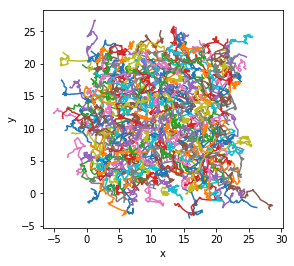

In [8]:
ax = plt.axes()
MD.AddParticleTraces(ax,x_tr,y_tr,range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

In [16]:
x_tr.shape

(1001, 256)

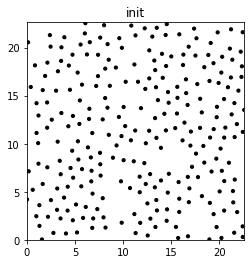

In [3]:
skip=10
MD.AnimateMDRun(t_tr[::skip],x_tr[::skip],y_tr[::skip],xBox=(0,LBox),yBox=(0,LBox),xpbc=True,ypbc=True,m=m)

## Tracer diffusion: particle mean-square displacements

In [9]:
def MeanSquareDisplacements(t_tr,x_tr):
    """
    Returns the particle and time average mean-square displacement < (x(t)-x(0))**2 > 
    in one Cartesian direction for a trajectory of x- or y-positions
    """
    
    NParticles = x_tr.shape[-1]
    delta_t_steps_max = t_tr.shape[-1]
    local_x_tr = np.copy(x_tr)

    if x_tr.ndim>2:
        # data for an ensemble of trajectories
        NTrajectories = x_tr.shape[-3]
        local_x_tr = local_x_tr.transpose(1,0,2)
        # so that the time axis is always the first axis (or rather axis=0)
    else:
        NTrajectories = 1
        
    msd = []
    delta_t = []
    
    for n in range(1,delta_t_steps_max//2):
        if t_tr.ndim==1:
            # data for one trajectories
            delta_t.append(t_tr[n]-t_tr[0])
        elif t_tr.ndim==2:
            # data for an ensemble of trajectories
            delta_t.append(t_tr[0,n]-t_tr[0,0])
        delta_x2 = ( local_x_tr - np.roll(local_x_tr,-n,axis=0) )**2
        msd.append(np.mean(delta_x2[:delta_t_steps_max-n]))
        
    return np.array(delta_t), np.array(msd)

In [10]:
delta_t, x_msd = MeanSquareDisplacements(t_tr,x_tr)

In [11]:
delta_t, y_msd = MeanSquareDisplacements(t_tr,y_tr)

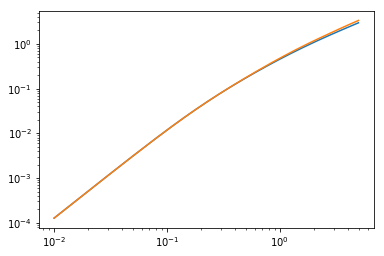

In [12]:
plt.loglog(delta_t,x_msd)
plt.loglog(delta_t,y_msd)

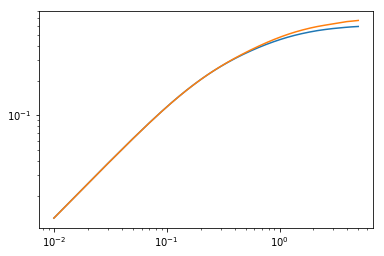

In [13]:
plt.loglog(delta_t,x_msd/delta_t)
plt.loglog(delta_t,y_msd/delta_t)

Test that the function also works for an ensemble

In [14]:
delta_t, xx_msd = MeanSquareDisplacements(np.array([t_tr,t_tr,t_tr]),np.array([x_tr,x_tr,x_tr]))

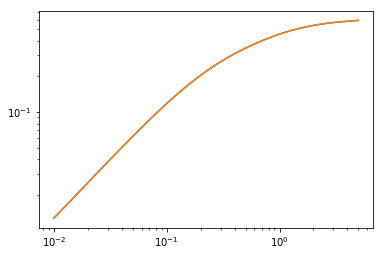

In [15]:
plt.loglog(delta_t,x_msd/delta_t)
plt.loglog(delta_t,xx_msd/delta_t)